In [19]:
import pandas as pd
import re
import json

file="mqtt_23may_30may"

with open(f"./mqtt_logs/{file}.log", "r") as f:
    log_lines = f.readlines()

results = []

for line in log_lines:
    line = line.strip()
    
    # Match WARNING lines with IMEI
    warning_match = re.match(r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+) \[None\] \[(\w+)\] .*?IMEI (\d+)", line)
    if warning_match:
        timestamp_a, msg_type, imei = warning_match.groups()
        results.append({
            "ts_client_received": timestamp_a,
            "ts_device_recorded": None,
            "msg_type": msg_type.lower(),
            "payload_size": None,
            "imei": imei
        })
        continue

    # Match INFO lines with payload
    info_match = re.match(
        r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+) \[None\] \[INFO\] .*?topic '(\d+)/data'.*?: (.*)$",
        line
    )
    if info_match:
        timestamp_a, imei, payload_str = info_match.groups()
        try:
            payload = json.loads(payload_str)
            ts_recorded = payload.get("state", {}).get("reported", {}).get("ts")
            results.append({
                "ts_client_received": timestamp_a,
                "ts_device_recorded": ts_recorded,
                "msg_type": "info",
                "payload_size": len(payload_str),
                "imei": imei
            })
        except json.JSONDecodeError:
            continue

# Convert to DataFrame
df = pd.DataFrame(results)

# Save or inspect results
df.to_csv(f"./mqtt_logs/parsed_{file}.csv", index=False)


In [20]:
df["ts_device_recorded"] = pd.to_datetime(df["ts_device_recorded"], unit="ms")

In [21]:
print(df.head(20))

         ts_client_received      ts_device_recorded msg_type  payload_size  \
0   2025-05-26 07:12:23,188 2025-05-26 07:11:54.020     info         326.0   
1   2025-05-26 07:12:26,739 2025-05-26 07:11:54.030     info         326.0   
2   2025-05-26 07:12:28,791 2025-05-26 07:11:54.040     info         326.0   
3   2025-05-26 07:12:30,151 2025-05-26 07:11:56.000     info         327.0   
4   2025-05-26 07:12:30,559 2025-05-26 07:12:01.000     info         326.0   
5   2025-05-26 07:12:34,532 2025-05-26 07:12:01.010     info         326.0   
6   2025-05-26 07:12:35,493 2025-05-26 07:12:01.020     info         326.0   
7   2025-05-26 07:12:36,813 2025-05-26 07:12:01.030     info         326.0   
8   2025-05-26 07:12:37,244 2025-05-26 07:12:09.000     info         326.0   
9   2025-05-26 07:12:38,992 2025-05-26 07:12:09.010     info         326.0   
10  2025-05-26 07:12:39,409 2025-05-26 07:12:09.020     info         326.0   
11  2025-05-26 07:12:41,587 2025-05-26 07:11:17.000     info    

/tmp/ipykernel_120942/1629570171.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ts_client_received"] = pd.to_datetime(df["ts_client_received"])


<Axes: title={'center': 'Message Latency Over Time'}, xlabel='ts_client_received', ylabel='Latency (ms)'>

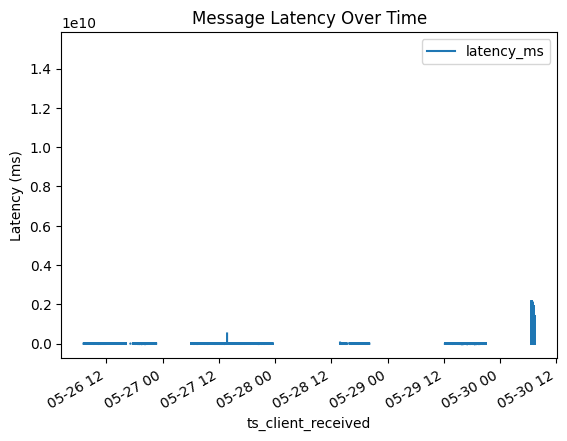

In [22]:
df["ts_client_received"] = pd.to_datetime(df["ts_client_received"])
df["ts_device_recorded"] = pd.to_datetime(df["ts_device_recorded"])
df["latency_ms"] = (df["ts_client_received"] - df["ts_device_recorded"]).dt.total_seconds() * 1000

df.plot(x="ts_client_received", y="latency_ms", title="Message Latency Over Time", ylabel="Latency (ms)")

<Axes: title={'center': 'Rolling Average Latency (window=5)'}, xlabel='ts_client_received'>

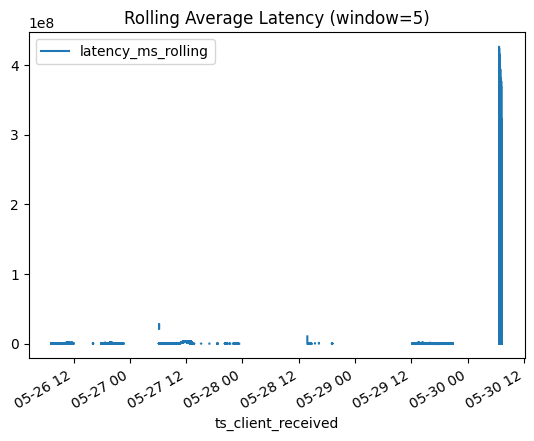

In [23]:
df["latency_ms_rolling"] = df["latency_ms"].rolling(window=5).mean()
df.plot(x="ts_client_received", y="latency_ms_rolling", title="Rolling Average Latency (window=5)")


<Axes: title={'center': 'Rolling Average Latency (window=5)'}, xlabel='ts_client_received'>

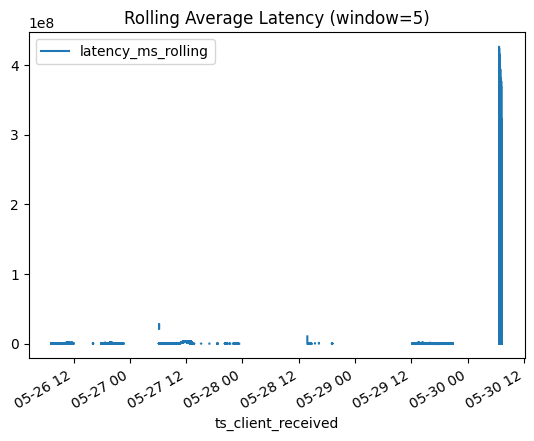

In [24]:
df["latency_ms_rolling"] = df["latency_ms"].rolling(window=5).mean()
df.plot(x="ts_client_received", y="latency_ms_rolling", title="Rolling Average Latency (window=5)")
